<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/evgen/mlp_eeg_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install h5py

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import backend as K
import keras.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import math
import os
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
###Added
import seaborn as sns
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor

Обработка данных

In [15]:
sfq = 250
wnd = 1
bias = 2
times = 12

In [16]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
class CrossWindow():
  
  def __init__(self, arr, n, add_tail=False):
    assert len(arr.shape) == 1
    sh = arr.shape[0]
    assert n < sh
    if sh%n == 0:
        self.arr = arr.reshape(n, sh//n)
    else:
        if add_tail:
            print(f'Warning: impossible to fit array in shape ({n}, {sh//n}), remaining tail will have size {sh%n}')
            self.arr = arr[:n*sh//n].reshape(n, sh//n)
        

In [18]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def coeff_determination_simp(y_true, y_pred):
    res = np.sum(np.square(y_true - y_pred))
    y_true_mean = np.tile(np.mean(y_true, axis=-1), y_true.shape[-1]).reshape((y_true.shape[-1], y_true.shape[-2])).T
    tot = np.sum(np.square(y_true - y_true_mean))
    return 1 - res/((tot + K.epsilon())*y_true.shape[0]*y_true.shape[1])

In [120]:
mapping = [
    ('O2','A2'),
    ('O1','A1'),
    ('P4','A2'),
    ('P3','A1'),
    ('C4','A2'),
    ('C3','A1'),
    ('F4','A2'),
    ('F3','A1'),
    ('Fp2','A2'),
    ('Fp1','A1'),
    ('T6','A2'),
    ('T5','A1'),
    ('T4','A2'),
    ('T3','A1'),
    ('F8','A2'),
    ('F7','A1'),
    ('Oz','A2'),
    ('Pz','A1'),
    ('Cz','A2'),
    ('Fz','A1'),
    ('Fpz','A2'),
    ('FT7','A1'),
    ('FC3','A1'),
    ('Fcz','A1'),
    ('FC4','A2'),
    ('FT8','A2'),
    ('TP7','A1'),
    ('CP3','A1'),
    ('Cpz','A1'),
    ('CP4','A2'),
    ('TP8','A2'), 
]
r_mapping = {mapping[i][0]:i for i in range(len(mapping))}
    

In [121]:
def normalize(arr:np.array):
    return (arr - arr.min())/(arr.max()-arr.min())

In [122]:
def extract(data_stream):
    raw_data = data_stream.readlines()
    data = []
    for line in raw_data:
        temp = np.array([float(x) for x in line.split()])
        data.append(temp)
    return np.array(data)

def format_fname(_group, _hand, _subj, _tr_num):
    directory = 'drive/My Drive/Subjects'
    fname_pattern = f'{_group}_subject_{_subj}_{_hand}_tr_{_tr_num}.dat'
    return join(directory, fname_pattern)

hands = ('lefthand', 'righthand')
groups = ('OLD', 'YOUNG')
subjects = np.arange(1, 11)
trials = np.arange(1, 16)
total = len(hands)*len(groups)*len(subjects)*len(trials)

In [123]:
epochs = []

for trial in trials:
    fin = open(format_fname('YOUNG', hands[1], subjects[0], trial))
    epochs.append(extract(fin))
    fin.close()

epochs = np.array(epochs)

In [124]:
t = np.linspace(0, 12, 3001)
tp7 = epochs[::, r_mapping['TP7'], ::]
cz = epochs[::, r_mapping['Cz'], ::]
lowcut = 8.0
highcut = 12.0
cz_filtered = butter_bandpass_filter(cz, lowcut, highcut, sfq, order=6)
tp7_filtered = butter_bandpass_filter(tp7, lowcut, highcut, sfq, order=6)
#tp7_filtered = np.array([(tp7_filtered[i] - np.min(tp7_filtered[i]))/(np.max(tp7_filtered[i]) - np.min(tp7_filtered[i])) for i in range(len(tp7_filtered))])
#cz_filtered = np.array([(cz_filtered[i] - np.min(cz_filtered[i]))/(np.max(cz_filtered[i]) - np.min(cz_filtered[i])) for i in range(len(cz_filtered))])

In [25]:
tp7_filtered = tp7_filtered.T
cz_filtered = cz_filtered.T
print(tp7_filtered.shape, cz_filtered.shape)

(3001, 15) (3001, 15)


Создание и тестирование нейросети

Создание модели

In [125]:
### Added
#Создание модели
def baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    #Компиляция модели
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(0.0001), metrics=[coeff_determination])
    return model

Early Stopping and checkpointing

In [ ]:
model_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'

In [ ]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='coeff_determination', verbose=0, mode='max', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(mode='min', patience=50, min_delta=0.001),
    tf.keras.callbacks.EarlyStopping(monitor='coeff_determination', mode='max', baseline=0.6, patience=20, min_delta=0.01)
]

NameError: ignored

Выделение тренировочного множества и его нормализация

Валидационное множество и его создание


In [139]:
### Validation set
src_predict1 = cz_filtered[14, sfq*6:sfq*11].T
trgt_predict1 = tp7_filtered[14, sfq*6:sfq*11].T
src_predict1 = normalize(src_predict1)
trgt_predict1 = normalize(trgt_predict1)

In [109]:

tf.keras.backend.set_floatx('float64')

In [140]:
### Model

for tr in range(14):
    src = cz_filtered[tr:tr+1, sfq*6:sfq*11].T
    trgt = tp7_filtered[tr:tr+1, sfq*6:sfq*11].T
    src = normalize(src)
    trgt = normalize(trgt)
    src_next = cz_filtered[tr:tr+1, sfq*6:sfq*11].T
    trgt_next = tp7_filtered[tr:tr+1, sfq*6:sfq*11].T
    model.fit(src, trgt, epochs = 10, batch_size=32, verbose=False)
    res = model.predict(src_next, verbose=False)
    c = coeff_determination_simp(trgt_next.T, res.T)
    print(f'Current trial: {tr} ### Second: {i}-{i+1} ### Fit: {c}')
    model = tf.keras.Sequential()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=[coeff_determination])
    print('@@@ New trial @@@')

### Prediction results
res = model.predict(src_predict1, batch_size=100)
mse = np.square(np.subtract(res, trgt_predict1)).mean()
print('R Squared: ', r2_score(trgt_predict1, res), "; MSE: ", mse)

Current trial: 0 ### Second: 13-14 ### Fit: 0.9975048048096566
@@@ New trial @@@
Current trial: 1 ### Second: 13-14 ### Fit: 0.9980863707531427
@@@ New trial @@@
Current trial: 2 ### Second: 13-14 ### Fit: 0.9982401104905999
@@@ New trial @@@
Current trial: 3 ### Second: 13-14 ### Fit: 0.9977855304067672
@@@ New trial @@@
Current trial: 4 ### Second: 13-14 ### Fit: 0.9983673601553122
@@@ New trial @@@
Current trial: 5 ### Second: 13-14 ### Fit: 0.9985122213473435
@@@ New trial @@@
Current trial: 6 ### Second: 13-14 ### Fit: 0.9973520806148621
@@@ New trial @@@
Current trial: 7 ### Second: 13-14 ### Fit: 0.9985711853947747
@@@ New trial @@@
Current trial: 8 ### Second: 13-14 ### Fit: 0.9969978234459413
@@@ New trial @@@
Current trial: 9 ### Second: 13-14 ### Fit: 0.9987452310985137
@@@ New trial @@@
Current trial: 10 ### Second: 13-14 ### Fit: 0.9982283636206766
@@@ New trial @@@
Current trial: 11 ### Second: 13-14 ### Fit: 0.9963554174952947
@@@ New trial @@@
Current trial: 12 ### Seco

Визуализация

In [141]:
model.evaluate(src_predict1,trgt_predict1)

40/40 [==============================] - 0s 2ms/step - loss: 0.0236 - coeff_determination: -1.5918


[0.02364748719036579, -1.591783179513393]

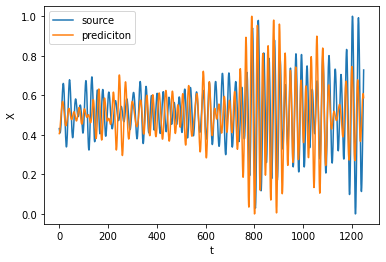

In [142]:
### Данные, которые мы предсказываем
a = range(0, 250)
plt.figure()
plt.plot(trgt_predict1[:], label='source')
plt.plot(res[:], label='prediciton')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [57]:
a = pd.DataFrame(histories.history)
a.describe()

NameError: ignored

In [95]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'val_loss')
    plt.legend()
    plt.show()


plot_history(histories)

NameError: ignored

In [94]:
def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('val_coeff_determination')
    plt.plot(hist['epoch'], hist['val_coeff_determination'],
           label='Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.legend()
    plt.show()


plot_history2(histories)

NameError: ignored

In [ ]:
hist = pd.DataFrame(histories.history)
hist.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,20.000000,20.000000,20.000000,20.000000
mean,0.012359,0.040077,0.016556,0.113504
std,0.000124,0.019009,0.000303,0.004164
min,0.012236,0.004607,0.015977,0.102537
25%,0.012262,0.028408,0.016331,0.110969
50%,0.012303,0.045739,0.016594,0.114384
75%,0.012436,0.054713,0.016813,0.115525
max,0.012611,0.062558,0.016940,0.120116


Cross-validation

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True)

TypeError: ignored

In [ ]:
### Source: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/ https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/


VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

save_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'
fold_var = 1

num_epochs = 500

for train_index, val_index in kf.split(np.zeros(n),Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "filename", y_col = "label",
                               class_mode = "categorical", shuffle = True)
    valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "filename", y_col = "label",
                            class_mode = "categorical", shuffle = True)
        
    # CREATE NEW MODEL
    model = baseline_model()
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                            monitor='val_accuracy', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                epochs=num_epochs,
                callbacks=callbacks_list,
                validation_data=valid_data_generator)
    #PLOT HISTORY
    #:
    #:
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

NameError: ignored

Проверка нахождения связей

In [ ]:
### Проверка нахождения связей
coefs = {}
for tr in range(15):
    start_time = time.time()
    temp = []
    for i in range(int(math.floor(2/wnd)), int(times/wnd)-1):
        model = baseline_model()
        src = cz_filtered[int(sfq*wnd*i):int(sfq*wnd*(i+1)), tr:tr+1]
        trgt = tp7_filtered[int(sfq*wnd*(i+1)):int(sfq*wnd*(i+2)), tr:tr+1]
        src = normalize(src)
        trgt = normalize(trgt)
        model.fit(src, trgt, epochs=500, batch_size=32, verbose=False, validation_split=0.3)
        src_full = cz_filtered[int(sfq*wnd*i):int(sfq*wnd*(i+1)):5, tr:tr+1]
        trgt_full = tp7_filtered[int(sfq*wnd*(i+1)):int(sfq*wnd*(i+2)):5, tr:tr+1]
        src_full = normalize(src)
        trgt_full = normalize(trgt)
        res = model.predict(src, verbose=False)
        c = r2_score(trgt, res)
#         estimator = KerasRegressor(build_fn=baseline_model, epochs=500, batch_size=32, verbose=0)
#         kfold = KFold(n_splits=10)
#         results = cross_val_score(estimator, src, trgt, cv=kfold)
        temp.append(c)
        print(f'Current trial: {tr} ### Second: {i*wnd}-{(i+1)*wnd} ### R Squared score: {c} ### Time of exec: {time.time() - start_time} seconds')
    coefs[tr] = temp
    print('@@@ New trial @@@')

Current trial: 0 ### Second: 2-3 ### R Squared score: -5.113173401778491 ### Time of exec: 27.320669889450073 seconds
Current trial: 0 ### Second: 3-4 ### R Squared score: -5.649287946189022 ### Time of exec: 54.999436378479004 seconds
Current trial: 0 ### Second: 4-5 ### R Squared score: -2.9839759822571166 ### Time of exec: 82.85009360313416 seconds
Current trial: 0 ### Second: 5-6 ### R Squared score: -4.440745344540382 ### Time of exec: 110.57078528404236 seconds
Current trial: 0 ### Second: 6-7 ### R Squared score: -9.218900708537673 ### Time of exec: 138.2177538871765 seconds
Current trial: 0 ### Second: 7-8 ### R Squared score: -7.002551480462921 ### Time of exec: 165.71445393562317 seconds
Current trial: 0 ### Second: 8-9 ### R Squared score: -4.69605460290859 ### Time of exec: 193.5099024772644 seconds
Current trial: 0 ### Second: 9-10 ### R Squared score: 0.02219815015949589 ### Time of exec: 220.88016843795776 seconds
Current trial: 0 ### Second: 10-11 ### R Squared score: -

In [ ]:
coefs = list(coefs.values())

In [ ]:
coefs = np.array(coefs)

In [ ]:
plt.hist(coefs.T)
plt.show()

In [ ]:
coefs.shape # 15 триалов, в каждом по 9 окон. массив хранит данные о фите для каждого окна

In [ ]:
len(coefs[0].shape)